# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [1]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [4]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [ ]:
n_chains = 3
n_edges_per_chain = 3
bar_radius = 0.7

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 200, 100, 100

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(bar_3d_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 1e-2,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": False,
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

ERROR:2025-11-19 08:57:34,438:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 471, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH


Number of vertices: 360
Number of faces: 708
SDF shape: (200, 100, 100)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

TODOs>
- fix bcs
- plot parts of jacobian for parameters
- scaling VN bcs instead of gradients in FD


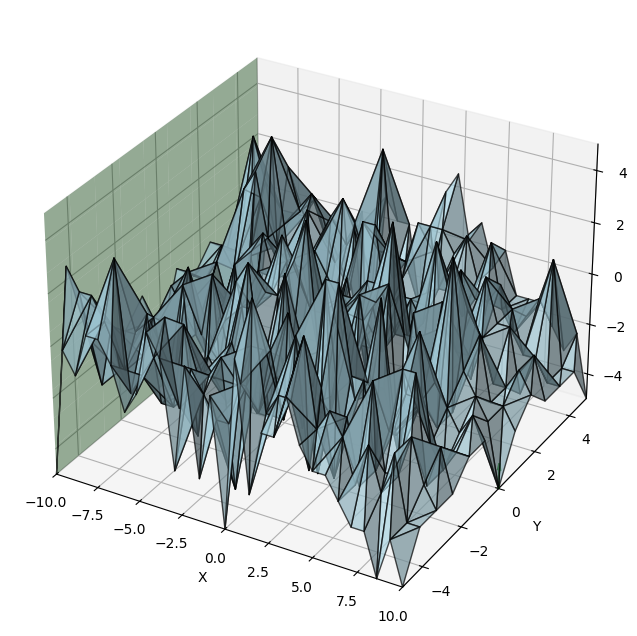

In [47]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

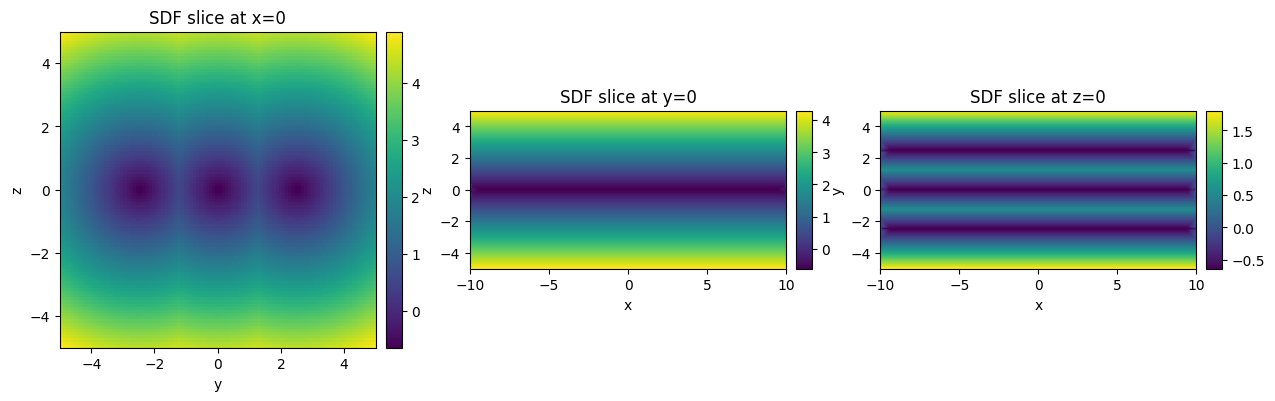

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

Lets test the gradient of the design Tesseract

In [6]:
# primal, vjp_fun = jax.vjp(
#     lambda params: apply_tesseract(
#         design_tess,
#         {
#             "differentiable_parameters": params.flatten(),
#             **design_inputs,
#         },
#     )["sdf"],
#     initial_params,
# )

# grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

# print("Gradient shape:", grad.shape)

And figure out an approate epsilon for finite difference based Jacobian computation.

In [7]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-6, 0, 6)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     primal, vjp_fun = jax.vjp(
#         lambda params, eps=eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params.flatten(),
#                 "non_differentiable_parameters": jnp.array(
#                     [bar_radius], dtype=jnp.float32
#                 ),
#                 "static_parameters": [n_chains, n_edges_per_chain + 1],
#                 "string_parameters": [],
#                 "mesh_tesseract": TesseractReference(bar_3d_tess),
#                 "grid_size": [Lx, Ly, Lz],
#                 "grid_elements": [Nx, Ny, Nz],
#                 "grid_center": [0.0, 0.0, 0.0],
#                 "epsilon": eps.item(),  # epsilon, only used for FD of the jacobian
#                 "normalize_jacobian": True,
#             },
#         )["sdf"],
#         initial_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [8]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

## Density and Sizing Field

rho min: 6.239625508897007e-05, rho max: 0.7989268898963928


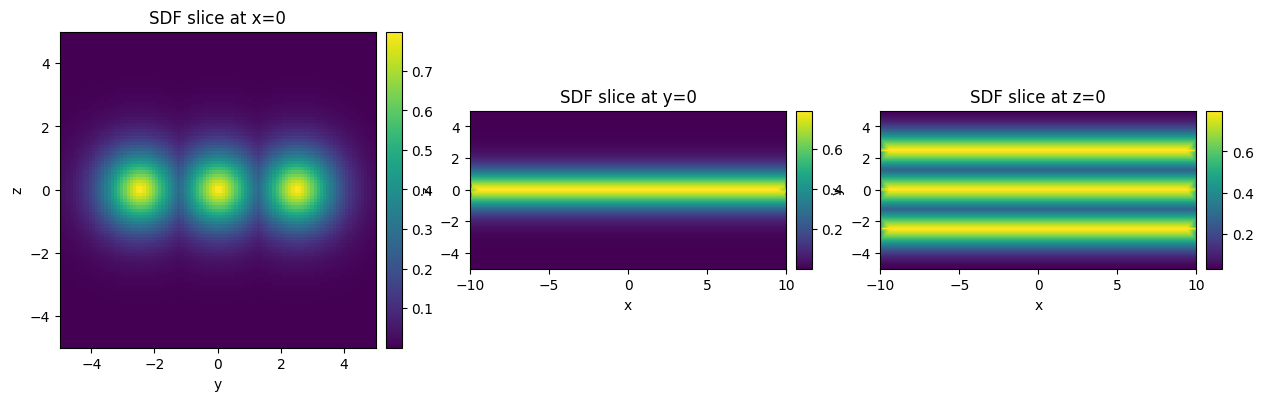

In [7]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 1.25, max: 2.4999918937683105


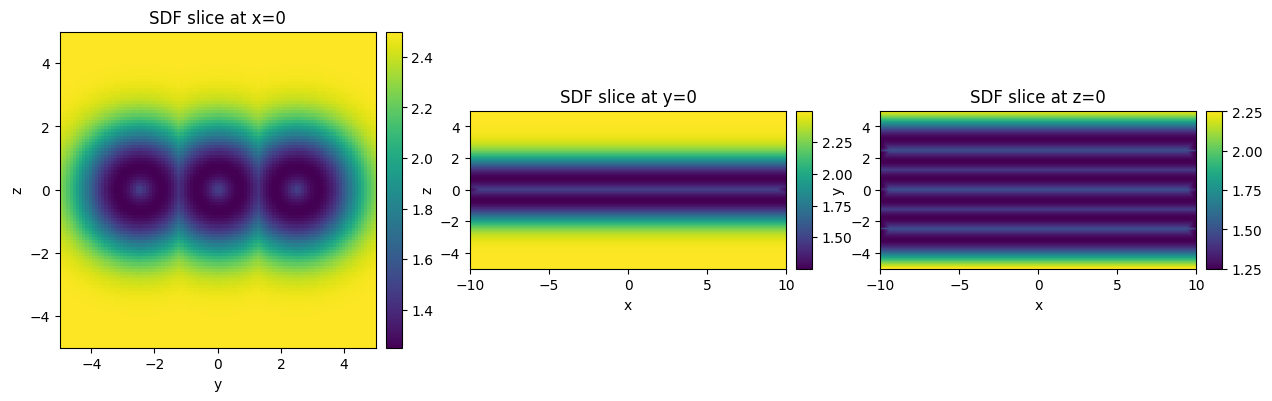

In [12]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 16
sizing_max = Lx / 8
sizing_scale = 1.0
sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [19]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        # "sizing_field": jnp.ones_like(sdf) * (Lx / 10),
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": 40000,
        "max_cells": 40000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

/anaconda/envs/fem/lib/python3.13/site-packages/numpy/_core/getlimits.py:559: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/anaconda/envs/fem/lib/python3.13/site-packages/numpy/_core/getlimits.py:91: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


No more subdivisions needed at level 2.
Mesh points: 2305, Mesh faces: 1680


Lets check the gradient of the meshing Tesseract

In [ ]:
# max_points = 5000
# max_cells = 5000

# primal, vjp_fun = jax.vjp(
#     lambda rho: apply_tesseract(
#         mesher,
#         {
#             "domain_size": [Lx, Ly, Lz],
#             "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
#             "field_values": rho,
#             "max_subdivision_levels": 4,
#             "max_points": max_points,
#             "max_cells": max_cells,
#         },
#     )["mesh_cell_values"],
#     rho,
# )

# grad = vjp_fun(jax.numpy.ones((max_cells), dtype=jax.numpy.float32) * 0.5)[0]

# print("Gradient shape:", grad.shape)
# print(f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}")

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [36]:
# Lets export it to a .vtk using pyvista
import numpy as np
import pyvista as pv


def hex_to_pyvista(
    pts: jax.typing.ArrayLike, faces: jax.typing.ArrayLike, cell_data: dict
) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).
        cell_data: additional cell center data.

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    pts = np.array(pts)
    faces = np.array(faces)

    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    mesh = pv.UnstructuredGrid(cells, cell_types, pts)

    # Add cell data
    for name, data in cell_data.items():
        mesh.cell_data[name] = data

    return mesh


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"][: adaptive_mesh["n_points"]])
cells_np = np.array(adaptive_mesh["faces"][: adaptive_mesh["n_faces"]])

hex_mesh = hex_to_pyvista(
    pts_np,
    cells_np,
    {"rho": mesher_out["mesh_cell_values"][: adaptive_mesh["n_faces"]]},
)

print(hex_mesh)

hex_mesh.save("bars_mesh.vtk")

UnstructuredGrid (0x709d0405c040)
  N Cells:    1680
  N Points:   2305
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   1


## Boundary Conditions

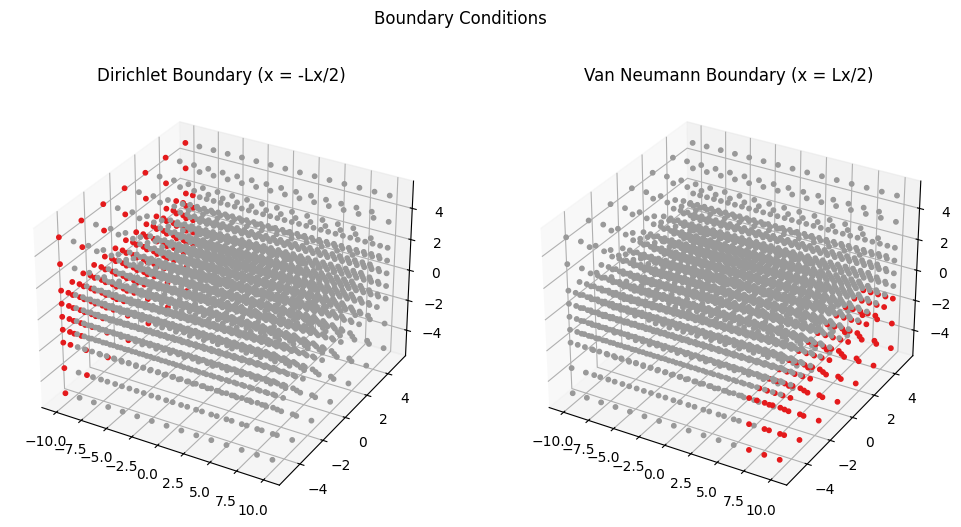

In [21]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 20
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 3),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [22]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [23]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 1.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-19 10:00:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:00:18][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:00:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-19 10:00:18][DEBUG] jax_fem: Done pre-computations, took 0.706129789352417 [s]
[11-19 10:00:18][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-19 10:00:18][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:00:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:00:18][DEBUG] jax_fem: Start timing
[11-19 10:00:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:00:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.1606 seconds
[11-19 10:00:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:00:19][DEBUG] jax_fem: Before, l_2 res = 57.584654626572366, relative l_2 res = 1.0
[11-19 10:00:19][DEBUG] jax_fem: Solving linear system...
[11-19 10:00:19][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:00:20][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 8.40632495626355e-10
[11-19 10:00:20][DEBUG] jax

Compliance: 3575.6445


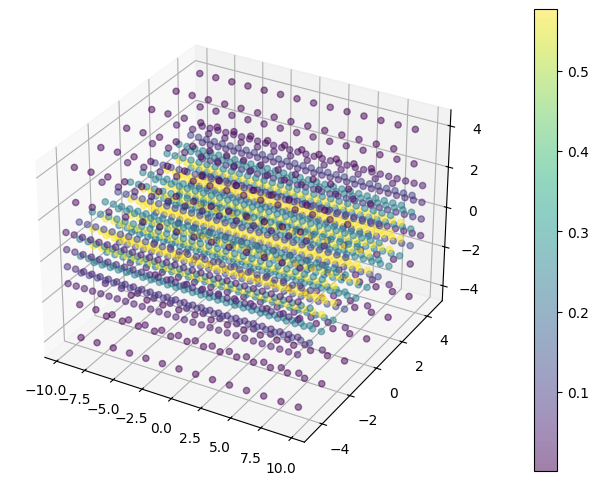

In [24]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [25]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)

In [28]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [ ]:
max_points = 15000
max_cells = 15000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    params = identity_and_store_grads(params, iteration + 0)
    sdf = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )["sdf"]

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho_grid,
            "max_subdivision_levels": 2,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)
    rho_cell = identity_and_store_grads(rho_cell, iteration + 3000)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 0.01]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    print(
        f"max points : {mesher_out['mesh']['n_points']}, max cells: {mesher_out['mesh']['n_faces']}"
    )

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "rho_cell": rho_cell,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [56]:
import optax

n_steps = 30
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.05, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.sgd(learning_rate=schedule)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []

grad_fn = jax.value_and_grad(loss, has_aux=True)

for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    aux_hist.append(aux)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    # params = params.at[..., 0].set(initial_params[..., 0])  # fix x-coordinates

    # Ensure parameters are within bounds
    params = params.at[..., 1].set(
        jnp.clip(params[..., 1], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    )

    # Clip the z-coordinates to be within the bar radius
    params = params.at[..., 2].set(
        jnp.clip(params[..., 2], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

[11-19 10:30:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:30:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:30:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:30:33][DEBUG] jax_fem: Done pre-computations, took 0.2985515594482422 [s]
[11-19 10:30:33][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-19 10:30:33][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:30:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:30:33][DEBUG] jax_fem: Start timing
[11-19 10:30:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:30:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.1946 seconds
[11-19 10:30:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:30:33][DEBUG] jax_fem: Before, l_2 res = 0.5758465333945504, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:30:35][DEBUG] jax_fem: Done pre-computations, took 0.3018510341644287 [s]
[11-19 10:30:35][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-19 10:30:35][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:30:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:30:35][DEBUG] jax_fem: Start timing
[11-19 10:30:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:30:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.1747 seconds
[11-19 10:30:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:30:35][DEBUG] jax_fem: Before, l_2 res = 0.5758465333945504, relative l_2 res = 1.0
[11-19 10:30:35][DEBUG] jax_fem: Solving linear system...
[11-19 10:30:35][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:30:36][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 9.926237558548627e-12
[11-19 10:30:36][DEBUG] j

Storing values in hash 3000
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
Storing values in hash 0
[ 2.5497031e-01  8.8516319e-01  4.1029766e-02 -2.4916315e-03
  1.5331222e+00 -1.3779432e-02 -1.7078714e-03  8.6912894e-01
  4.5398501e-01  6.3089974e-02  4.3953699e-01  1.5065200e+00
  1.2333171e+00  2.4430239e-01  5.4326713e-02  8.6271134e-04
  2.6347476e-01  4.5619816e-02 -9.5558641e-03  1.8000251e-01
  1.7155917e-01  1.4048915e-02  1.5564927e-01  5.8505046e-01
  2.5454801e-01 -4.1974270e-01  4.0973768e-02 -1.5854214e-03
 -9.8807001e-01 -9.4115287e-03  1.0618391e-03 -5.1041073e-01
  4.5555729e-01  6.2411379e-02 -1.1650066e-01  1.5078419e+00]
[-10.         -2.5         0.         -3.3333328  -2.5         0.
   3.333334   -2.5         0.         10.         -2.5         0.
 -10.          0.          0.         -3.3333328   0.          0.
   3.333334    0.          0.         10.          0.          0.
 -10.          2.5         0.         -3.3333328   2.5 

[11-19 10:30:48][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:30:48][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:30:48][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:30:48][DEBUG] jax_fem: Done pre-computations, took 0.30026888847351074 [s]
[11-19 10:30:48][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-19 10:30:48][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:30:48][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:30:48][DEBUG] jax_fem: Start timing
[11-19 10:30:48][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:30:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.1776 seconds
[11-19 10:30:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:30:48][DEBUG] jax_fem: Before, l_2 res = 0.5758465333945504, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:30:50][DEBUG] jax_fem: Done pre-computations, took 0.3056354522705078 [s]
[11-19 10:30:50][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-19 10:30:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:30:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:30:50][DEBUG] jax_fem: Start timing
[11-19 10:30:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:30:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.1691 seconds
[11-19 10:30:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:30:50][DEBUG] jax_fem: Before, l_2 res = 0.5758465333945504, relative l_2 res = 1.0
[11-19 10:30:50][DEBUG] jax_fem: Solving linear system...
[11-19 10:30:50][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:30:51][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 9.970911181526196e-12
[11-19 10:30:51][DEBUG] j

Storing values in hash 3001
Storing values in hash 2001
Storing values in hash 1001
Computing Jacobian...
Storing values in hash 1
[ 1.6689396   0.8522267   0.11375444 -0.15414797  0.86320627 -0.02071786
 -0.01652603  0.2611238   0.38789454  0.293187    0.24364825  1.3390346
 -2.4353456   0.36363405  0.2412272   0.30986863  0.39228565  0.1398988
 -0.03437616  0.4023653   0.21700816 -0.48851374  0.07037741  0.57093626
  1.8054512  -0.9719723   0.1429912  -0.11856965 -1.0500257   0.1483374
  0.00346763 -0.54999864  0.5181654   0.34925756 -0.25952658  1.3467922 ]
[-1.00127487e+01 -2.54425812e+00 -2.05148826e-03 -3.33320808e+00
 -2.57665610e+00  6.88971602e-04  3.33341932e+00 -2.54345655e+00
 -2.26992499e-02  9.99684525e+00 -2.52197695e+00 -7.53260031e-02
 -1.00616655e+01 -1.22151198e-02 -2.71633570e-03 -3.33337593e+00
 -1.31737385e-02 -2.28099083e-03  3.33381176e+00 -9.00012534e-03
 -8.57795868e-03  9.99929714e+00 -7.78246392e-03 -2.92525236e-02
 -1.00127277e+01  2.52098703e+00 -2.0486884

[11-19 10:31:04][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:31:04][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:31:04][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:31:04][DEBUG] jax_fem: Done pre-computations, took 0.3062756061553955 [s]
[11-19 10:31:04][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-19 10:31:04][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:31:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:31:04][DEBUG] jax_fem: Start timing
[11-19 10:31:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:31:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.1757 seconds
[11-19 10:31:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:31:04][DEBUG] jax_fem: Before, l_2 res = 0.5758465333945504, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:31:06][DEBUG] jax_fem: Done pre-computations, took 0.302304744720459 [s]
[11-19 10:31:06][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[11-19 10:31:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:31:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:31:06][DEBUG] jax_fem: Start timing
[11-19 10:31:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:31:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.1700 seconds
[11-19 10:31:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:31:06][DEBUG] jax_fem: Before, l_2 res = 0.5758465333945504, relative l_2 res = 1.0
[11-19 10:31:06][DEBUG] jax_fem: Solving linear system...
[11-19 10:31:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:31:07][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.0437841678887179e-11
[11-19 10:31:07][DEBUG] j

Storing values in hash 3002
Storing values in hash 2002
Storing values in hash 1002
Computing Jacobian...
Storing values in hash 2
[-2.6309564e+00  9.4386405e-01  4.1877425e-01  5.0041628e-01
  2.6379137e+00  2.7393121e-01  5.4797675e-02  1.0018451e+00
  8.2451463e-01 -6.1965841e-01  2.6293546e-01  1.3171382e+00
  8.5012598e+00  5.4287982e-01  1.5442282e-01 -3.9712346e-01
  5.4596114e-01  1.5696949e-01 -6.7243882e-02  4.0070839e-02
  8.1469804e-02  2.1147771e+00 -3.4784712e-03  4.5625761e-01
 -2.3341565e+00 -3.0756474e-01  4.9295777e-01  3.6314070e-01
 -1.3049068e+00  3.9921325e-01  5.9327129e-02 -7.2646803e-01
  8.1616485e-01 -5.2523679e-01 -2.4201162e-01  1.3034363e+00]
[-1.0095903e+01 -2.5867200e+00 -7.7192700e-03 -3.3255277e+00
 -2.6196651e+00  1.7212329e-03  3.3342428e+00 -2.5564671e+00
 -4.2025983e-02  9.9822369e+00 -2.5341167e+00 -1.4204301e-01
 -9.9403248e+00 -3.0333079e-02 -1.4735410e-02 -3.3488150e+00
 -3.2719254e-02 -9.2514083e-03  3.3355246e+00 -2.9047858e-02
 -1.9390326e-0

[11-19 10:31:24][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:31:24][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:31:24][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:31:25][DEBUG] jax_fem: Done pre-computations, took 0.8085284233093262 [s]
[11-19 10:31:25][INFO] jax_fem: Solving a problem with 1708 cells, 2346x3 = 7038 dofs.
[11-19 10:31:25][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:31:27][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:31:27][DEBUG] jax_fem: Start timing
[11-19 10:31:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:31:28][DEBUG] jax_fem: Function split_and_compute_cell took 0.5240 seconds
[11-19 10:31:28][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:31:29][DEBUG] jax_fem: Before, l_2 res = 0.5380494937273864, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:31:31][DEBUG] jax_fem: Done pre-computations, took 0.995192289352417 [s]
[11-19 10:31:31][INFO] jax_fem: Solving a problem with 1708 cells, 2346x3 = 7038 dofs.
[11-19 10:31:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:31:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:31:33][DEBUG] jax_fem: Start timing
[11-19 10:31:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:31:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.5290 seconds
[11-19 10:31:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:31:35][DEBUG] jax_fem: Before, l_2 res = 0.5380494937273864, relative l_2 res = 1.0
[11-19 10:31:35][DEBUG] jax_fem: Solving linear system...
[11-19 10:31:35][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:31:36][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 8.406837075984444e-12
[11-19 10:31:36][DEBUG] ja

Storing values in hash 3003
Storing values in hash 2003
Storing values in hash 1003
Computing Jacobian...
Storing values in hash 3
[ 13.819362     4.9232206   -0.09247216  -0.7634814    4.214192
   0.47849035  -0.1643884    1.0192043    0.1744568    6.77304
   0.26235697   1.3265941  -13.563727     1.6389658    6.473661
   5.234752     5.447849     0.90917957   0.69495565   3.9790301
   4.244386    -2.9262872    0.21590172   1.7804534   17.651514
  -3.4079828    3.182414    -0.6868526   -0.33155832   1.5225372
  -0.16427143   0.13411005   1.3691177    6.628362    -0.22256091
   1.3001529 ]
[ -9.965277    -2.6335828   -0.02851142  -3.3503733   -2.7506375
  -0.01187946   3.3315222   -2.6062088   -0.08296315  10.013003
  -2.5471716   -0.20743896 -10.362412    -0.05728708  -0.02240251
  -3.3290977   -0.05982624  -0.01704495   3.3388631   -0.03103738
  -0.0234353    9.918638    -0.01111629  -0.08035246  -9.9867935
   2.584686    -0.03364855  -3.3453758    2.6665092   -0.02674124
   3.330162

[11-19 10:31:59][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:31:59][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:31:59][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:32:00][DEBUG] jax_fem: Done pre-computations, took 1.0999071598052979 [s]
[11-19 10:32:00][INFO] jax_fem: Solving a problem with 1946 cells, 2638x3 = 7914 dofs.
[11-19 10:32:00][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:32:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:32:02][DEBUG] jax_fem: Start timing
[11-19 10:32:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:32:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.5669 seconds
[11-19 10:32:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:32:04][DEBUG] jax_fem: Before, l_2 res = 0.4894918190371544, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:32:08][DEBUG] jax_fem: Done pre-computations, took 1.237743616104126 [s]
[11-19 10:32:08][INFO] jax_fem: Solving a problem with 1946 cells, 2638x3 = 7914 dofs.
[11-19 10:32:08][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:32:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:32:09][DEBUG] jax_fem: Start timing
[11-19 10:32:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:32:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.5382 seconds
[11-19 10:32:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:32:12][DEBUG] jax_fem: Before, l_2 res = 0.4894918190371544, relative l_2 res = 1.0
[11-19 10:32:12][DEBUG] jax_fem: Solving linear system...
[11-19 10:32:12][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:32:13][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.7254729192506634e-11
[11-19 10:32:13][DEBUG] j

Storing values in hash 3004
Storing values in hash 2004
Storing values in hash 1004
Computing Jacobian...
Storing values in hash 4
[  0.51498944   8.847584    -5.1977587    2.4834285   13.759638
  -5.900454    -0.02013113   3.4663026    2.4720397   -0.5010431
   1.1663108    1.1393995   11.0049305    2.7961411    8.6704445
  -0.15134984   3.3299088    1.7206081   -0.07726851   2.9775307
   1.5896726   10.122719     0.76292586   0.6177168   -1.9113426
 -10.530375    -7.368561    -1.1912146  -10.122103    -4.233065
   0.20648004   0.3865608    0.63150066   0.30677843  -0.758528
   0.5207192 ]
[-10.649003    -2.877164    -0.02393628  -3.3125992   -2.9591386
  -0.03555323   3.3396554   -2.6566348   -0.09159457   9.6779
  -2.560152    -0.2730735   -9.691334    -0.13837649  -0.34269312
  -3.588092    -0.32936382  -0.06202748   3.3044796   -0.22790372
  -0.23343042  10.063419    -0.02179824  -0.1684421  -10.860119
   2.7532992   -0.19110155  -3.311393     2.6829133   -0.10207024
   3.3382897 

[11-19 10:32:38][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:32:38][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:32:38][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:32:39][DEBUG] jax_fem: Done pre-computations, took 1.1502501964569092 [s]
[11-19 10:32:39][INFO] jax_fem: Solving a problem with 2184 cells, 2920x3 = 8760 dofs.
[11-19 10:32:39][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:32:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:32:40][DEBUG] jax_fem: Start timing
[11-19 10:32:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:32:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.5504 seconds
[11-19 10:32:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:32:42][DEBUG] jax_fem: Before, l_2 res = 0.48594630063235034, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:32:45][DEBUG] jax_fem: Done pre-computations, took 1.2682826519012451 [s]
[11-19 10:32:45][INFO] jax_fem: Solving a problem with 2184 cells, 2920x3 = 8760 dofs.
[11-19 10:32:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:32:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:32:47][DEBUG] jax_fem: Start timing
[11-19 10:32:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:32:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.5410 seconds
[11-19 10:32:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:32:48][DEBUG] jax_fem: Before, l_2 res = 0.48594630063235034, relative l_2 res = 1.0
[11-19 10:32:48][DEBUG] jax_fem: Solving linear system...
[11-19 10:32:49][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:32:50][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.3161175005408444e-11
[11-19 10:32:50][DEBUG]

Storing values in hash 3005
Storing values in hash 2005
Storing values in hash 1005
Computing Jacobian...
Storing values in hash 5
[ -3.421743    -0.3092454   -7.439058     0.9137176   -1.1423923
 -17.162651     0.54068255   1.8925539   -5.177424    -1.9176668
   0.72073185   0.8511736   13.30402      1.8373076   25.124722
  -2.0421553    2.8357406   34.300426    -0.39822873  -1.1585699
   7.869822     9.196272     1.1416254    1.0558361   -1.3042159
   0.11027025  -7.26429      0.614182     0.6204848  -14.279432
   0.26899946   0.99182796  -3.244234    -0.28387648  -0.32731152
   0.3638405 ]
[-10.674394    -3.313372     0.23232627  -3.4350383   -3.6375232
   0.25535393   3.340648    -2.8275323   -0.21347232   9.702603
  -2.617654    -0.32924876 -10.233905    -0.27623326  -0.77016777
  -3.58063     -0.49353668  -0.14685777   3.308289    -0.37470347
  -0.31180525   9.564344    -0.0594124   -0.1988971  -10.765885
   3.272473     0.17218697  -3.2526631    3.1819584    0.10663047
   3.3281

[11-19 10:33:13][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:33:13][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:33:13][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:33:15][DEBUG] jax_fem: Done pre-computations, took 1.1828994750976562 [s]
[11-19 10:33:15][INFO] jax_fem: Solving a problem with 2289 cells, 3086x3 = 9258 dofs.
[11-19 10:33:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:33:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:33:17][DEBUG] jax_fem: Start timing
[11-19 10:33:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:33:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.5153 seconds
[11-19 10:33:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:33:19][DEBUG] jax_fem: Before, l_2 res = 0.4877222816329847, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:33:22][DEBUG] jax_fem: Done pre-computations, took 1.3455185890197754 [s]
[11-19 10:33:22][INFO] jax_fem: Solving a problem with 2289 cells, 3086x3 = 9258 dofs.
[11-19 10:33:22][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:33:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:33:24][DEBUG] jax_fem: Start timing
[11-19 10:33:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:33:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.4971 seconds
[11-19 10:33:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:33:26][DEBUG] jax_fem: Before, l_2 res = 0.4877222816329847, relative l_2 res = 1.0
[11-19 10:33:26][DEBUG] jax_fem: Solving linear system...
[11-19 10:33:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:33:28][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 6.5001700122903995e-12
[11-19 10:33:28][DEBUG] 

Storing values in hash 3006
Storing values in hash 2006
Storing values in hash 1006
Computing Jacobian...
Storing values in hash 6
[  4.063642     0.06453767 -10.741232    -0.05941876  -3.372747
 -15.884108    -0.80210483  -4.302891    -5.6699443    3.2472124
  -0.54465795   0.8618319   -1.047343     0.51340806  15.4203415
  -1.7446051    0.04109925  27.482594    -1.3392137    0.57598794
  14.289969    -2.7156348   -0.293397     1.2103763    1.8556654
   0.5312153   -9.62241     -0.17923662   2.5524282  -15.436636
  -0.19983113   7.5639553   -2.1502838    4.55516      1.9256804
   1.1663045 ]
[-10.506285    -3.2981787    0.59780467  -3.479929    -3.5813978
   1.0985491    3.3140843   -2.920513     0.04089276   9.796818
  -2.6530633   -0.37106663 -10.8875265   -0.36649954  -2.0045369
  -3.4802997   -0.63285565  -1.8320261    3.327854    -0.31778333
  -0.6984469    9.1125345   -0.11550006  -0.25076997 -10.70181
   3.2670555    0.5290791   -3.2828376    3.1514742    0.80817413
   3.314894

[11-19 10:33:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:33:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:33:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:33:56][DEBUG] jax_fem: Done pre-computations, took 1.2126555442810059 [s]
[11-19 10:33:56][INFO] jax_fem: Solving a problem with 2562 cells, 3397x3 = 10191 dofs.
[11-19 10:33:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:33:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:33:58][DEBUG] jax_fem: Start timing
[11-19 10:33:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:33:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.4872 seconds
[11-19 10:34:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:34:00][DEBUG] jax_fem: Before, l_2 res = 0.488371625585778, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:34:03][DEBUG] jax_fem: Done pre-computations, took 1.3548815250396729 [s]
[11-19 10:34:03][INFO] jax_fem: Solving a problem with 2562 cells, 3397x3 = 10191 dofs.
[11-19 10:34:03][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:34:05][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:34:05][DEBUG] jax_fem: Start timing
[11-19 10:34:05][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:34:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.4740 seconds
[11-19 10:34:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:34:08][DEBUG] jax_fem: Before, l_2 res = 0.488371625585778, relative l_2 res = 1.0
[11-19 10:34:08][DEBUG] jax_fem: Solving linear system...
[11-19 10:34:08][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:34:09][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 3.3248540415038084e-12
[11-19 10:34:09][DEBUG] 

Storing values in hash 3007
Storing values in hash 2007
Storing values in hash 1007
Computing Jacobian...
Storing values in hash 7
[ 1.0301299e+00  9.7586691e-01 -6.2201285e+00 -7.3228143e-03
 -1.0535419e+00 -4.4378061e+00  1.5750983e-01 -2.4000201e+00
 -1.7690842e-01  7.3852450e-01 -5.1730299e-01  1.2037299e+00
  2.0791392e+00 -4.7610879e-02  9.6703091e+00 -7.1323180e-01
 -3.1340880e+00  5.6835127e+00 -1.1183100e+00  7.3756480e-01
  4.0212660e+00 -1.9869696e+00  8.1515205e-01  1.1799755e+00
  8.3798671e-01  1.7979646e-01 -4.3972745e+00  6.9632731e-02
  1.8618094e+00 -4.3324523e+00  2.7105176e-01  2.7322845e+00
  8.3087534e-01  3.4018106e+00  2.3390062e+00  1.8827726e+00]
[-10.70523     -3.3013382    1.1236677   -3.47702     -3.4162767
   1.876194     3.3533533   -2.7098546    0.31847858   9.637842
  -2.6263983   -0.41325969 -10.836251    -0.39163467  -2.759477
  -3.3948884   -0.6348678   -3.177503     3.3934183   -0.3459822
  -1.398047     9.245485    -0.1011361   -0.31002688 -10.7926

[11-19 10:34:37][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:34:37][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:34:37][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:34:38][DEBUG] jax_fem: Done pre-computations, took 1.1923739910125732 [s]
[11-19 10:34:38][INFO] jax_fem: Solving a problem with 2548 cells, 3424x3 = 10272 dofs.
[11-19 10:34:38][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:34:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:34:40][DEBUG] jax_fem: Start timing
[11-19 10:34:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:34:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.5335 seconds
[11-19 10:34:41][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:34:42][DEBUG] jax_fem: Before, l_2 res = 0.48724885679731283, relative l_2 

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:34:45][DEBUG] jax_fem: Done pre-computations, took 1.320718765258789 [s]
[11-19 10:34:45][INFO] jax_fem: Solving a problem with 2548 cells, 3424x3 = 10272 dofs.
[11-19 10:34:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:34:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:34:46][DEBUG] jax_fem: Start timing
[11-19 10:34:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:34:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.5414 seconds
[11-19 10:34:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:34:48][DEBUG] jax_fem: Before, l_2 res = 0.48724885679731283, relative l_2 res = 1.0
[11-19 10:34:48][DEBUG] jax_fem: Solving linear system...
[11-19 10:34:48][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:34:49][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.992461484817157e-12
[11-19 10:34:49][DEBUG] 

Storing values in hash 3008
Storing values in hash 2008
Storing values in hash 1008
Computing Jacobian...
Storing values in hash 8
[ 1.2167264  -0.16181421 -4.657567   -0.03415977 -2.1273608  -3.1021378
 -0.26832905 -1.442016   -0.7237766   0.7385539  -0.0591263   1.0057609
  1.5822134  -0.02156663  8.675304   -0.41041774 -2.1564782   5.1848555
 -0.5194555   0.48222166  2.4389124   1.0330038   1.1219199   2.2796373
  0.31220907  0.5970925  -4.191416   -0.11628576  1.5283234  -3.4415164
  0.26774353  1.3952289   0.39562103  0.6764256   0.98411006  1.237941  ]
[-10.755486    -3.3489466    1.4271215   -3.4766629   -3.364879
   2.0926957    3.345669    -2.5927677    0.3271092    9.601812
  -2.6011612   -0.4719846  -10.937684    -0.38931194  -3.2312505
  -3.3600929   -0.48196888  -3.4547777    3.4479759   -0.38196486
  -1.5942276    9.342422    -0.14090393  -0.3675929  -10.833541
   3.2322772    1.2146919   -3.2774596    2.9356842    1.775274
   3.3114538    2.010963     0.03613468   9.2874

[11-19 10:35:17][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:35:17][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:35:17][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:35:18][DEBUG] jax_fem: Done pre-computations, took 1.1839814186096191 [s]
[11-19 10:35:18][INFO] jax_fem: Solving a problem with 2520 cells, 3405x3 = 10215 dofs.
[11-19 10:35:18][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:35:20][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:35:20][DEBUG] jax_fem: Start timing
[11-19 10:35:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:35:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.2795 seconds
[11-19 10:35:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:35:21][DEBUG] jax_fem: Before, l_2 res = 0.48724885679731283, relative l_2 

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:35:24][DEBUG] jax_fem: Done pre-computations, took 1.3430917263031006 [s]
[11-19 10:35:24][INFO] jax_fem: Solving a problem with 2520 cells, 3405x3 = 10215 dofs.
[11-19 10:35:24][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:35:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:35:26][DEBUG] jax_fem: Start timing
[11-19 10:35:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:35:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.2557 seconds
[11-19 10:35:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:35:27][DEBUG] jax_fem: Before, l_2 res = 0.48724885679731283, relative l_2 res = 1.0
[11-19 10:35:27][DEBUG] jax_fem: Solving linear system...
[11-19 10:35:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:35:28][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.1972960895315092e-12
[11-19 10:35:28][DEBUG

Storing values in hash 3009
Storing values in hash 2009
Storing values in hash 1009
Computing Jacobian...
Storing values in hash 9
[ 0.8517582   0.49296167 -3.4904027  -0.13645622 -0.35131538 -2.4717674
 -0.16822582 -0.6319442  -0.5458659   0.5515854   0.21338993  1.0544755
  0.12633215  0.47326338  5.5337057  -0.49004388  0.3456853   1.7078251
 -0.39817977 -0.47311845  1.6558022   0.12075762  0.9168558   2.0946748
  0.10068659  0.33404395 -3.4533203  -0.0721131   0.9582146  -2.3955824
  0.10848983  0.70725685  0.23702711  0.566043    0.67469335  1.2967579 ]
[-10.814636    -3.34108      1.653548    -3.4750023   -3.2614577
   2.2435052    3.3587139   -2.5226645    0.3622954    9.5659075
  -2.5982869   -0.5208794  -11.014603    -0.3882635   -3.6529982
  -3.3401406   -0.37713224  -3.7068381    3.4732292   -0.40540794
  -1.7127947    9.292202    -0.19544578  -0.4784169  -10.848719
   3.2032497    1.4184564   -3.2718065    2.861385     1.9425825
   3.2984376    1.9431343    0.01690166   9.2

[11-19 10:35:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:35:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:35:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:35:56][DEBUG] jax_fem: Done pre-computations, took 1.2002367973327637 [s]
[11-19 10:35:56][INFO] jax_fem: Solving a problem with 2576 cells, 3464x3 = 10392 dofs.
[11-19 10:35:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:35:58][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:35:58][DEBUG] jax_fem: Start timing
[11-19 10:35:58][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:35:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.4661 seconds
[11-19 10:35:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:35:59][DEBUG] jax_fem: Before, l_2 res = 0.48724885679731283, relative l_2 

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:36:02][DEBUG] jax_fem: Done pre-computations, took 1.3490312099456787 [s]
[11-19 10:36:02][INFO] jax_fem: Solving a problem with 2576 cells, 3464x3 = 10392 dofs.
[11-19 10:36:02][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:36:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:36:04][DEBUG] jax_fem: Start timing
[11-19 10:36:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:36:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.4597 seconds
[11-19 10:36:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:36:05][DEBUG] jax_fem: Before, l_2 res = 0.48724885679731283, relative l_2 res = 1.0
[11-19 10:36:05][DEBUG] jax_fem: Solving linear system...
[11-19 10:36:05][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:36:06][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.7058311393443727e-12
[11-19 10:36:06][DEBUG

Storing values in hash 3010
Storing values in hash 2010
Storing values in hash 1010
Computing Jacobian...
Storing values in hash 10
[ 0.6018755   0.22043246 -2.8713982  -0.21255326 -0.2538832  -1.5907042
 -0.01001135 -0.668853   -0.42857552  0.6863899   0.141292    1.0783534
  0.4726842   0.7373003   6.646549   -0.44429123  0.74978375  3.3933947
 -0.12703933  0.06947656  1.1816953   0.7021743   1.0008925   2.282979
  0.02872108  0.22197446 -2.7411027  -0.03938245  0.7149923  -1.5007837
 -0.00706459  0.5515755   0.17644721  0.11388385  0.33308756  1.2288399 ]
[-1.0855899e+01 -3.3649611e+00  1.8226382e+00 -3.4683917e+00
 -3.2444384e+00  2.3632483e+00  3.3668635e+00 -2.4920504e+00
  3.8873950e-01  9.5391865e+00 -2.6086245e+00 -5.7196271e-01
 -1.1020722e+01 -4.1119042e-01 -3.9210749e+00 -3.3164008e+00
 -3.9387873e-01 -3.7895725e+00  3.4925187e+00 -3.8248804e-01
 -1.7930088e+00  9.2863522e+00 -2.3986222e-01 -5.7989198e-01
 -1.0853597e+01  3.1870673e+00  1.5857501e+00 -3.2683129e+00
  2.8149

[11-19 10:36:35][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:36:35][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:36:35][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:36:36][DEBUG] jax_fem: Done pre-computations, took 0.9657070636749268 [s]
[11-19 10:36:36][INFO] jax_fem: Solving a problem with 2569 cells, 3457x3 = 10371 dofs.
[11-19 10:36:36][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:36:37][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:36:37][DEBUG] jax_fem: Start timing
[11-19 10:36:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:36:39][DEBUG] jax_fem: Function split_and_compute_cell took 1.9065 seconds
[11-19 10:36:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:36:40][DEBUG] jax_fem: Before, l_2 res = 0.4872488567973128, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:36:43][DEBUG] jax_fem: Done pre-computations, took 1.1662178039550781 [s]
[11-19 10:36:43][INFO] jax_fem: Solving a problem with 2569 cells, 3457x3 = 10371 dofs.
[11-19 10:36:43][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:36:44][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:36:44][DEBUG] jax_fem: Start timing
[11-19 10:36:44][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:36:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.4967 seconds
[11-19 10:36:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:36:46][DEBUG] jax_fem: Before, l_2 res = 0.4872488567973128, relative l_2 res = 1.0
[11-19 10:36:46][DEBUG] jax_fem: Solving linear system...
[11-19 10:36:46][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:36:46][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.682808557259669e-12
[11-19 10:36:47][DEBUG] 

Storing values in hash 3011
Storing values in hash 2011
Storing values in hash 1011
Computing Jacobian...
Storing values in hash 11
[ 8.2895011e-01  2.5380710e-01 -2.6757460e+00 -2.5338748e-01
 -2.1492162e-01 -1.5240543e+00  4.2877357e-02 -4.5046374e-01
 -2.4803309e-01  5.5204165e-01 -2.4605762e-02  9.9407029e-01
  3.7467158e-01  1.7632723e-01  3.9726791e+00 -4.4902456e-01
 -4.3003085e-01  1.0935659e+00 -2.7952451e-01 -6.0842896e-01
  1.4016013e+00  2.5292301e-01  1.1483668e+00  1.5761044e+00
  1.6350769e-02 -3.9092743e-01 -2.7017145e+00  2.4020858e-03
  1.3326500e-01 -1.5472076e+00  7.7669829e-02  3.5625196e-01
  1.1129826e-03  3.8063410e-01  4.3728402e-01  1.3134930e+00]
[-1.0884954e+01 -3.3756025e+00  1.9612534e+00 -3.4581308e+00
 -3.2321823e+00  2.4400387e+00  3.3673468e+00 -2.4597619e+00
  4.0942875e-01  9.5060511e+00 -2.6154451e+00 -6.2401962e-01
 -1.1043541e+01 -4.4678319e-01 -4.2419333e+00 -3.2949529e+00
 -4.3007416e-01 -3.9533868e+00  3.4986515e+00 -3.8584200e-01
 -1.8500545e+

[11-19 10:37:10][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:37:10][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:37:10][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:37:11][DEBUG] jax_fem: Done pre-computations, took 0.7326915264129639 [s]
[11-19 10:37:11][INFO] jax_fem: Solving a problem with 2562 cells, 3457x3 = 10371 dofs.
[11-19 10:37:11][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:37:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:37:11][DEBUG] jax_fem: Start timing
[11-19 10:37:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:37:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.3057 seconds
[11-19 10:37:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:37:13][DEBUG] jax_fem: Before, l_2 res = 0.4865980145605584, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:37:15][DEBUG] jax_fem: Done pre-computations, took 0.6973776817321777 [s]
[11-19 10:37:15][INFO] jax_fem: Solving a problem with 2562 cells, 3457x3 = 10371 dofs.
[11-19 10:37:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:37:16][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:37:16][DEBUG] jax_fem: Start timing
[11-19 10:37:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:37:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.3294 seconds
[11-19 10:37:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:37:17][DEBUG] jax_fem: Before, l_2 res = 0.4865980145605584, relative l_2 res = 1.0
[11-19 10:37:17][DEBUG] jax_fem: Solving linear system...
[11-19 10:37:17][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:37:18][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.203610712087125e-12
[11-19 10:37:18][DEBUG] 

Storing values in hash 3012
Storing values in hash 2012
Storing values in hash 1012
Computing Jacobian...
Storing values in hash 12
[ 0.22873667  0.15417121 -2.8550782  -0.24743572 -0.34301925 -1.6763839
 -0.08285791 -0.71977675 -0.1378293   0.283297    1.1503223   0.7770128
  0.14044368 -0.25257307  2.3576732  -0.13818233 -0.38895893  0.5514739
 -0.07345129  0.03191936  1.3192158   1.9181492   2.154541    3.1168687
  0.189016   -0.03852628 -2.5039215  -0.05585241  0.4650728  -1.3253617
 -0.00720423  0.42700475  0.182693    0.24419709  0.39054352  1.3088651 ]
[-1.0924831e+01 -3.3878119e+00  2.0899708e+00 -3.4459417e+00
 -3.2218435e+00  2.5133536e+00  3.3652842e+00 -2.4380922e+00
  4.2136043e-01  9.4794950e+00 -2.6142614e+00 -6.7183959e-01
 -1.1061564e+01 -4.5526543e-01 -4.4330401e+00 -3.2733524e+00
 -4.0938741e-01 -4.0059929e+00  3.5120981e+00 -3.5657337e-01
 -1.9174788e+00  9.2402878e+00 -3.4342223e-01 -7.6592040e-01
 -1.0855770e+01  3.1951573e+00  1.8480420e+00 -3.2665274e+00
  2.774

[11-19 10:37:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:37:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:37:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:37:42][DEBUG] jax_fem: Done pre-computations, took 0.9395401477813721 [s]
[11-19 10:37:42][INFO] jax_fem: Solving a problem with 2555 cells, 3450x3 = 10350 dofs.
[11-19 10:37:42][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:37:43][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:37:43][DEBUG] jax_fem: Start timing
[11-19 10:37:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:37:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.4915 seconds
[11-19 10:37:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:37:45][DEBUG] jax_fem: Before, l_2 res = 0.4865980145605584, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:37:47][DEBUG] jax_fem: Done pre-computations, took 1.1671319007873535 [s]
[11-19 10:37:47][INFO] jax_fem: Solving a problem with 2555 cells, 3450x3 = 10350 dofs.
[11-19 10:37:47][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:37:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:37:49][DEBUG] jax_fem: Start timing
[11-19 10:37:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:37:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.4950 seconds
[11-19 10:37:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:37:50][DEBUG] jax_fem: Before, l_2 res = 0.4865980145605584, relative l_2 res = 1.0
[11-19 10:37:50][DEBUG] jax_fem: Solving linear system...
[11-19 10:37:50][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:37:51][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.007370314744574e-12
[11-19 10:37:51][DEBUG] 

Storing values in hash 3013
Storing values in hash 2013
Storing values in hash 1013
Computing Jacobian...
Storing values in hash 13
[ 0.3595599   0.14550033 -2.865437   -0.23702727 -0.31928602 -1.957246
 -0.26257858 -0.2802848  -0.4099422   0.9140143   0.02065187  1.0080726
  0.18989548  0.4562279   1.3378017  -0.01341854  0.4367712  -0.1102241
 -0.09727224 -0.03557894  1.0554314  -0.24626578  0.99057907  1.4162626
  0.32263273 -0.09766286 -2.456722   -0.25050902  0.452218   -1.048829
  0.11664607  0.0288607   0.10478099  0.9161781   0.4129799   1.3467221 ]
[-10.935796    -3.3952024    2.2268336   -3.4340804   -3.2054002
   2.5937138    3.369256    -2.4035885    0.4279675    9.465915
  -2.6694038   -0.70908695 -11.068296    -0.44315794  -4.546059
  -3.2667284   -0.39074206  -4.0324287    3.515619    -0.35810348
  -1.9807175    9.148338    -0.44670355  -0.91533244 -10.864831
   3.197004     1.9680715   -3.26385      2.7517443    2.2690463
   3.2901318    1.844638    -0.01191006   9.1916

[11-19 10:38:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:38:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:38:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:38:15][DEBUG] jax_fem: Done pre-computations, took 0.9407191276550293 [s]
[11-19 10:38:15][INFO] jax_fem: Solving a problem with 2548 cells, 3446x3 = 10338 dofs.
[11-19 10:38:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:38:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:38:15][DEBUG] jax_fem: Start timing
[11-19 10:38:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:38:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.3592 seconds
[11-19 10:38:16][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:38:16][DEBUG] jax_fem: Before, l_2 res = 0.4865980145605584, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:38:19][DEBUG] jax_fem: Done pre-computations, took 1.1746001243591309 [s]
[11-19 10:38:19][INFO] jax_fem: Solving a problem with 2548 cells, 3446x3 = 10338 dofs.
[11-19 10:38:19][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:38:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:38:19][DEBUG] jax_fem: Start timing
[11-19 10:38:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:38:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.3574 seconds
[11-19 10:38:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:38:20][DEBUG] jax_fem: Before, l_2 res = 0.4865980145605584, relative l_2 res = 1.0
[11-19 10:38:20][DEBUG] jax_fem: Solving linear system...
[11-19 10:38:20][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:38:21][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.0181056302854927e-12
[11-19 10:38:21][DEBUG]

Storing values in hash 3014
Storing values in hash 2014
Storing values in hash 1014
Computing Jacobian...
Storing values in hash 14
[ 0.56462336  0.38700125 -2.579636   -0.14592889 -0.32568336 -1.4182633
 -0.03653068 -0.45713744 -0.17138207  0.5667938   0.17163545  0.99122393
  0.2531828  -0.32834846  0.7053021   0.17959026 -0.11084589 -0.54997957
 -0.18217081 -0.12124825  0.88137674  0.30108     0.37609962  1.5826004
 -0.03515595  0.22375716 -2.2848856  -0.11012989  0.6810769  -1.2637261
  0.11274506  0.31711927  0.24119581  0.0400392   0.27444774  1.4601653 ]
[-10.952971    -3.4021528    2.3637114   -3.4227579   -3.1901484
   2.6872084    3.381799    -2.3901997    0.44754982   9.422254
  -2.6703904   -0.7572411  -11.077368    -0.46495128  -4.609964
  -3.2660875   -0.41160598  -4.0271635    3.5202656   -0.35640392
  -2.031134     9.160102    -0.49402204  -0.9829852  -10.880242
   3.2016692    2.0854254   -3.2518835    2.7301426    2.3191473
   3.2845597    1.8432593   -0.0169153    9.

[11-19 10:38:39][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:38:39][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:38:39][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:38:40][DEBUG] jax_fem: Done pre-computations, took 0.962376594543457 [s]
[11-19 10:38:40][INFO] jax_fem: Solving a problem with 2576 cells, 3477x3 = 10431 dofs.
[11-19 10:38:40][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:38:41][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:38:41][DEBUG] jax_fem: Start timing
[11-19 10:38:41][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:38:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.3072 seconds
[11-19 10:38:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:38:42][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:38:45][DEBUG] jax_fem: Done pre-computations, took 1.134277105331421 [s]
[11-19 10:38:45][INFO] jax_fem: Solving a problem with 2576 cells, 3477x3 = 10431 dofs.
[11-19 10:38:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:38:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:38:46][DEBUG] jax_fem: Start timing
[11-19 10:38:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:38:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.3016 seconds
[11-19 10:38:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:38:47][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 res = 1.0
[11-19 10:38:47][DEBUG] jax_fem: Solving linear system...
[11-19 10:38:47][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:38:48][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.758289865604524e-12
[11-19 10:38:48][DEBUG] 

Storing values in hash 3015
Storing values in hash 2015
Storing values in hash 1015
Computing Jacobian...
Storing values in hash 15
[ 0.452633    0.20520648 -2.3763123  -0.19261444 -0.44978112 -1.1920516
 -0.04014846 -0.38471544 -0.22450292  0.3808289  -0.02295154  0.96750313
  0.25738615  0.05225232  0.47505668  0.15074222  0.06632726 -0.1635153
 -0.01573022  0.02917647  0.6273368   0.2078925   0.5337929   1.4561433
  0.17582719  0.0892323  -2.7057328  -0.16871321  0.33705795 -1.5343409
  0.18249978  0.3212114   0.2668348  -0.08987129  0.20851615  1.5204312 ]
[-10.979848    -3.4205744    2.4865048   -3.4158115   -3.1746454
   2.7547193    3.3835378   -2.3684394    0.4557078    9.395273
  -2.6785605   -0.80442435 -11.089419    -0.44932154  -4.643537
  -3.2746363   -0.4063296   -4.0009837    3.528937    -0.35063237
  -2.0730884    9.14577     -0.5119248   -1.0583186  -10.878569
   3.191018     2.1941884   -3.2466412    2.6977227    2.379302
   3.279193     1.8281641   -0.02839647   9.14

[11-19 10:39:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:39:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:39:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:39:06][DEBUG] jax_fem: Done pre-computations, took 0.44493937492370605 [s]
[11-19 10:39:06][INFO] jax_fem: Solving a problem with 2576 cells, 3477x3 = 10431 dofs.
[11-19 10:39:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:39:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:39:06][DEBUG] jax_fem: Start timing
[11-19 10:39:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:39:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.3038 seconds
[11-19 10:39:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:39:06][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:39:08][DEBUG] jax_fem: Done pre-computations, took 0.44612622261047363 [s]
[11-19 10:39:08][INFO] jax_fem: Solving a problem with 2576 cells, 3477x3 = 10431 dofs.
[11-19 10:39:08][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:39:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:39:08][DEBUG] jax_fem: Start timing
[11-19 10:39:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:39:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.3078 seconds
[11-19 10:39:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:39:08][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 res = 1.0
[11-19 10:39:08][DEBUG] jax_fem: Solving linear system...
[11-19 10:39:08][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:39:09][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.8150980647716022e-12
[11-19 10:39:09][DEBU

Storing values in hash 3016
Storing values in hash 2016
Storing values in hash 1016
Computing Jacobian...
Storing values in hash 16
[ 0.4052104   0.1766091  -2.1747456  -0.17707615 -0.45058906 -1.1914892
 -0.0951786  -0.41359136 -0.29883194  0.00405355  0.09289012  1.030534
  0.17028537 -0.33070782  0.11752504  0.06709036 -0.43374664 -0.4528979
 -0.05296382 -0.40344408  0.4271296   0.0224333   0.38441926  1.5360425
  0.27124608  0.08750585 -2.3338442  -0.2187964   0.61308086 -1.2058089
  0.15321007  0.31536195  0.3294543   0.14283402  0.33039224  1.5645707 ]
[-11.001318    -3.4303083    2.5992231   -3.406675    -3.1533105
   2.8112633    3.3854423   -2.3501909    0.4663569    9.377209
  -2.6774719   -0.85031706 -11.101628    -0.45180008  -4.666071
  -3.2817867   -0.40947577  -3.9932275    3.5296834   -0.35201633
  -2.1028457    9.135909    -0.5372448   -1.1273896  -10.886909
   3.1867855    2.3225324   -3.2386384    2.6817346    2.4520822
   3.2705362    1.8129277   -0.04105356   9.150

[11-19 10:39:31][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:39:31][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:39:31][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:39:32][DEBUG] jax_fem: Done pre-computations, took 0.9563503265380859 [s]
[11-19 10:39:32][INFO] jax_fem: Solving a problem with 2604 cells, 3497x3 = 10491 dofs.
[11-19 10:39:32][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:39:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:39:33][DEBUG] jax_fem: Start timing
[11-19 10:39:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:39:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.4598 seconds
[11-19 10:39:35][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:39:35][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:39:37][DEBUG] jax_fem: Done pre-computations, took 1.1312735080718994 [s]
[11-19 10:39:37][INFO] jax_fem: Solving a problem with 2604 cells, 3497x3 = 10491 dofs.
[11-19 10:39:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:39:39][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:39:39][DEBUG] jax_fem: Start timing
[11-19 10:39:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:39:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.4541 seconds
[11-19 10:39:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:39:40][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 res = 1.0
[11-19 10:39:40][DEBUG] jax_fem: Solving linear system...
[11-19 10:39:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:39:41][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.7870383784822063e-12
[11-19 10:39:41][DEBUG

Storing values in hash 3017
Storing values in hash 2017
Storing values in hash 1017
Computing Jacobian...
Storing values in hash 17
[ 0.37725815  0.3307816  -1.9154713  -0.09054939 -0.00728827 -0.66442245
 -0.08093706 -0.38609815  0.00468514  0.12296607  0.05248254  1.0736138
  0.0946495  -0.2735095   0.3413349  -0.08486925 -0.48040694 -0.53410184
 -0.06325018 -0.12044561  0.4485652  -0.07796019  0.40677464  1.5460999
  0.22619966  0.04767448 -2.1565084  -0.13243589  0.46998215 -1.074186
  0.16658713  0.42444712  0.23835243 -0.0842801   0.26441687  1.6186551 ]
[-11.020472    -3.4386563    2.7020187   -3.3983052   -3.1320121
   2.8675826    3.3899412   -2.3306413    0.48048204   9.377017
  -2.6818626   -0.8990282  -11.109677    -0.43616822  -4.671626
  -3.284958    -0.3889735   -3.9718199    3.5321867   -0.3329464
  -2.1230352    9.134849    -0.55541545  -1.199995   -10.89973
   3.1826491    2.4328482   -3.2282963    2.6527555    2.5090783
   3.2632942    1.7980212   -0.05662616   9.143

[11-19 10:40:03][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:40:03][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:40:03][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:40:04][DEBUG] jax_fem: Done pre-computations, took 0.44935107231140137 [s]
[11-19 10:40:04][INFO] jax_fem: Solving a problem with 2604 cells, 3497x3 = 10491 dofs.
[11-19 10:40:04][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:40:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:40:04][DEBUG] jax_fem: Start timing
[11-19 10:40:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:40:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.3106 seconds
[11-19 10:40:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:40:04][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:40:06][DEBUG] jax_fem: Done pre-computations, took 0.45566701889038086 [s]
[11-19 10:40:06][INFO] jax_fem: Solving a problem with 2604 cells, 3497x3 = 10491 dofs.
[11-19 10:40:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:40:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:40:06][DEBUG] jax_fem: Start timing
[11-19 10:40:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:40:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.3045 seconds
[11-19 10:40:06][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:40:06][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 res = 1.0
[11-19 10:40:06][DEBUG] jax_fem: Solving linear system...
[11-19 10:40:06][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:40:07][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.7158571921712082e-12
[11-19 10:40:07][DEBU

Storing values in hash 3018
Storing values in hash 2018
Storing values in hash 1018
Computing Jacobian...
Storing values in hash 18
[ 2.79277265e-01  3.57574999e-01 -2.13859320e+00 -2.83803284e-01
 -2.17959225e-01 -8.73544097e-01 -1.00916661e-01 -5.99382281e-01
 -1.84245318e-01  4.63150181e-02  1.24328785e-01  1.08758759e+00
  2.32183456e-01  1.45980462e-01  5.24568439e-01  6.89574778e-02
 -1.77212059e-04  1.63266957e-01  2.31499523e-02  1.35064021e-01
  6.35533810e-01  3.08122009e-01  3.65220577e-01  1.50012314e+00
  1.24198876e-01  1.06100678e-01 -1.95411384e+00 -1.11171305e-01
  3.13558996e-01 -1.02796388e+00  5.07454574e-02  4.05698597e-01
  1.08713396e-01 -2.35268354e-01  2.05932736e-01  1.68482161e+00]
[-11.038241    -3.4542367    2.7922416   -3.39404     -3.1316688
   2.8988783    3.3937535   -2.3124552    0.48026136   9.371225
  -2.6843345   -0.9495977  -11.114136    -0.42328534  -4.6877036
  -3.2809603   -0.36634532  -3.9466624    3.535166    -0.32727313
  -2.1441636    9.1385

[11-19 10:40:28][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:40:28][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:40:28][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:40:29][DEBUG] jax_fem: Done pre-computations, took 0.9717700481414795 [s]
[11-19 10:40:29][INFO] jax_fem: Solving a problem with 2597 cells, 3490x3 = 10470 dofs.
[11-19 10:40:29][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:40:31][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:40:31][DEBUG] jax_fem: Start timing
[11-19 10:40:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:40:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.5397 seconds
[11-19 10:40:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:40:32][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:40:35][DEBUG] jax_fem: Done pre-computations, took 1.153489589691162 [s]
[11-19 10:40:35][INFO] jax_fem: Solving a problem with 2597 cells, 3490x3 = 10470 dofs.
[11-19 10:40:35][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:40:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:40:36][DEBUG] jax_fem: Start timing
[11-19 10:40:36][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:40:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.5270 seconds
[11-19 10:40:38][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:40:38][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 res = 1.0
[11-19 10:40:38][DEBUG] jax_fem: Solving linear system...
[11-19 10:40:38][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:40:38][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.6345854409864552e-12
[11-19 10:40:39][DEBUG]

Storing values in hash 3019
Storing values in hash 2019
Storing values in hash 1019
Computing Jacobian...
Storing values in hash 19
[ 0.38513952  0.13368535 -1.7301948  -0.15621401 -0.21754202 -0.42597744
 -0.01767677 -0.3391611  -0.08296813  0.17164414  0.10901986  1.0710273
  0.40214354  0.17719892  0.29386827  0.02498821  0.21164659 -0.12984139
 -0.01357903  0.3330385   0.4940197   0.35159385  0.5147974   1.4493992
  0.11184038  0.11603377 -2.0646586  -0.15663968  0.2864185  -0.69928
  0.18214078  0.5858017   0.22608906  0.10030799  0.178913    1.8571784 ]
[-11.05135     -3.4710202    2.8926208   -3.3807192   -3.1214385
   2.93988      3.3984902   -2.284322     0.48890927   9.369052
  -2.69017     -1.0006459  -11.125033    -0.43013722  -4.712325
  -3.284197    -0.366337    -3.9543257    3.5340796   -0.33361262
  -2.1739936    9.124058    -0.5917178   -1.343231   -10.916214
   3.1754234    2.6261446   -3.2168403    2.6159008    2.6079242
   3.2530658    1.7589866   -0.07295576   9.15

[11-19 10:41:06][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:41:06][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:41:06][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:41:07][DEBUG] jax_fem: Done pre-computations, took 0.957014799118042 [s]
[11-19 10:41:07][INFO] jax_fem: Solving a problem with 2611 cells, 3504x3 = 10512 dofs.
[11-19 10:41:07][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:41:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:41:08][DEBUG] jax_fem: Start timing
[11-19 10:41:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:41:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.5303 seconds
[11-19 10:41:09][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:41:09][DEBUG] jax_fem: Before, l_2 res = 0.4816940247039691, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:41:12][DEBUG] jax_fem: Done pre-computations, took 1.1709697246551514 [s]
[11-19 10:41:12][INFO] jax_fem: Solving a problem with 2611 cells, 3504x3 = 10512 dofs.
[11-19 10:41:12][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:41:14][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:41:14][DEBUG] jax_fem: Start timing
[11-19 10:41:14][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:41:15][DEBUG] jax_fem: Function split_and_compute_cell took 0.5093 seconds
[11-19 10:41:15][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:41:15][DEBUG] jax_fem: Before, l_2 res = 0.4816940247039691, relative l_2 res = 1.0
[11-19 10:41:15][DEBUG] jax_fem: Solving linear system...
[11-19 10:41:15][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:41:16][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.6078832067232207e-12
[11-19 10:41:16][DEBUG]

Storing values in hash 3020
Storing values in hash 2020
Storing values in hash 1020
Computing Jacobian...
Storing values in hash 20
[ 0.32561582  0.384087   -2.0384727  -0.35193324 -0.13366824 -0.794993
 -0.04683556 -0.19322595 -0.2098184   0.10312222  0.09430069  1.039852
  0.0445957  -0.2129643   0.2524808  -0.2012329  -0.33499396 -0.40608776
  0.04368081 -0.33724448  0.05576679  0.11951333  0.4470056   0.9047943
  0.10418247  0.10125379 -1.7409313  -0.08456927  0.43375427 -0.4471448
  0.16755448  0.61858356  0.3171037   0.24000382  0.19386621  1.9474101 ]
[-11.069364    -3.477273     2.9735463   -3.3734126   -3.1112635
   2.9598038    3.399317    -2.2684586    0.4927899    9.361024
  -2.695269    -1.0507405  -11.143843    -0.43842524  -4.72607
  -3.2853658   -0.37623623  -3.9482527    3.5347147   -0.34918964
  -2.1971002    9.107613    -0.61579615  -1.4110229  -10.921445
   3.1699963    2.7227137   -3.209514     2.6025043    2.6406312
   3.2445467    1.7315872   -0.0835305    9.1538

[11-19 10:41:44][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:41:44][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:41:44][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:41:45][DEBUG] jax_fem: Done pre-computations, took 0.97743821144104 [s]
[11-19 10:41:45][INFO] jax_fem: Solving a problem with 2618 cells, 3510x3 = 10530 dofs.
[11-19 10:41:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:41:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:41:47][DEBUG] jax_fem: Start timing
[11-19 10:41:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:41:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.4816 seconds
[11-19 10:41:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:41:48][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:41:51][DEBUG] jax_fem: Done pre-computations, took 1.1887550354003906 [s]
[11-19 10:41:51][INFO] jax_fem: Solving a problem with 2618 cells, 3510x3 = 10530 dofs.
[11-19 10:41:51][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:41:52][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:41:52][DEBUG] jax_fem: Start timing
[11-19 10:41:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:41:53][DEBUG] jax_fem: Function split_and_compute_cell took 0.5010 seconds
[11-19 10:41:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:41:54][DEBUG] jax_fem: Before, l_2 res = 0.48169402470396905, relative l_2 res = 1.0
[11-19 10:41:54][DEBUG] jax_fem: Solving linear system...
[11-19 10:41:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:41:55][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.7361361358587552e-12
[11-19 10:41:55][DEBUG

Storing values in hash 3021
Storing values in hash 2021
Storing values in hash 1021
Computing Jacobian...
Storing values in hash 21
[ 0.58043987  0.26276094 -2.3080993  -0.22542441  0.00907509 -0.9512116
 -0.05795439 -0.4404416  -0.22397512  0.06902687 -0.09427914  0.93529
  0.2469653   0.00382626  0.38280016  0.08637197 -0.18443508 -0.35206276
  0.00259053 -0.0803668   0.4192082   0.3954469   0.4591485   0.858079
  0.32403547  0.22441165 -2.0180023  -0.08926895  0.5016664  -0.7596591
  0.13015106  0.3605931  -0.0088864   0.15651321  0.0479915   1.8556397 ]
[-11.08454     -3.4951746    3.0685563   -3.3570096   -3.1050334
   2.9968572    3.4015      -2.2594526    0.5025692    9.356217
  -2.6996644   -1.0992064  -11.145922    -0.4284993   -4.737838
  -3.2759867   -0.36062267  -3.9293256    3.5326788   -0.33347118
  -2.1996994    9.102042    -0.6366304   -1.453194   -10.926301
   3.165277     2.803856    -3.2055724    2.5822875    2.6614718
   3.2367373    1.7027559   -0.09831022   9.1426

[11-19 10:42:22][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:42:22][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:42:22][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:42:23][DEBUG] jax_fem: Done pre-computations, took 1.0095148086547852 [s]
[11-19 10:42:23][INFO] jax_fem: Solving a problem with 2625 cells, 3529x3 = 10587 dofs.
[11-19 10:42:23][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:42:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:42:24][DEBUG] jax_fem: Start timing
[11-19 10:42:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:42:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.5164 seconds
[11-19 10:42:26][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:42:26][DEBUG] jax_fem: Before, l_2 res = 0.4713339743852277, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:42:29][DEBUG] jax_fem: Done pre-computations, took 1.1754558086395264 [s]
[11-19 10:42:29][INFO] jax_fem: Solving a problem with 2625 cells, 3529x3 = 10587 dofs.
[11-19 10:42:29][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:42:31][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:42:31][DEBUG] jax_fem: Start timing
[11-19 10:42:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:42:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.5101 seconds
[11-19 10:42:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:42:33][DEBUG] jax_fem: Before, l_2 res = 0.4713339743852277, relative l_2 res = 1.0
[11-19 10:42:33][DEBUG] jax_fem: Solving linear system...
[11-19 10:42:33][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:42:34][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.8611830535093377e-12
[11-19 10:42:34][DEBUG]

Storing values in hash 3022
Storing values in hash 2022
Storing values in hash 1022
Computing Jacobian...
Storing values in hash 22
[ 0.13238405  0.08258861 -2.6270566  -0.55980575 -0.46086246 -1.743978
  0.01783653 -0.49606016 -0.1930106   0.07629347  0.00307884  1.1286141
  0.16535103 -0.02128532  0.16716078  0.00706469  0.20390707 -0.32181567
 -0.0575167  -0.03898932  0.26726323  0.64315045  0.51958394  0.7375716
  0.13329566  0.18220966 -1.9432003   0.02830623  0.40511817 -0.67129683
 -0.03343165  0.2079806  -0.04161653  0.26105437  0.0816187   1.8317919 ]
[-11.111499    -3.5073786    3.1757562   -3.3465397   -3.105455
   3.0410364    3.4041917   -2.2389963    0.51297176   9.353011
  -2.6952856   -1.1426461  -11.1573925   -0.42867702  -4.755617
  -3.2799983   -0.35205656  -3.9129739    3.5325584   -0.32973853
  -2.2191696    9.083675    -0.6579556   -1.4930476  -10.941351
   3.1548543    2.8975823   -3.2014263    2.5589876    2.6967542
   3.2306924    1.6860081   -0.09789749   9.13

[11-19 10:42:58][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:42:58][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:42:58][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:42:59][DEBUG] jax_fem: Done pre-computations, took 1.3721413612365723 [s]
[11-19 10:42:59][INFO] jax_fem: Solving a problem with 2597 cells, 3495x3 = 10485 dofs.
[11-19 10:42:59][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:42:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:42:59][DEBUG] jax_fem: Start timing
[11-19 10:43:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:43:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.3654 seconds
[11-19 10:43:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:43:01][DEBUG] jax_fem: Before, l_2 res = 0.4713339743852277, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:43:04][DEBUG] jax_fem: Done pre-computations, took 1.4698567390441895 [s]
[11-19 10:43:04][INFO] jax_fem: Solving a problem with 2597 cells, 3495x3 = 10485 dofs.
[11-19 10:43:04][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:43:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:43:04][DEBUG] jax_fem: Start timing
[11-19 10:43:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:43:05][DEBUG] jax_fem: Function split_and_compute_cell took 0.3501 seconds
[11-19 10:43:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:43:05][DEBUG] jax_fem: Before, l_2 res = 0.4713339743852277, relative l_2 res = 1.0
[11-19 10:43:05][DEBUG] jax_fem: Solving linear system...
[11-19 10:43:05][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:43:06][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.9261180201725044e-12
[11-19 10:43:06][DEBUG]

Storing values in hash 3023
Storing values in hash 2023
Storing values in hash 1023
Computing Jacobian...
Storing values in hash 23
[ 0.10759789  0.07014408 -2.5323112  -0.3013426  -0.5195096  -1.4566712
 -0.05525037 -0.48137137 -0.18002746  0.0599838   0.08667949  1.0281537
  0.30295086  0.07451782  0.27403513 -0.01774171  0.06644087  0.00651199
 -0.02705881  0.12639372  0.45725077  0.290411    0.30543634  0.6960733
  0.04364729 -0.02659157 -1.7185197  -0.17599086  0.26274645 -0.5083668
  0.13442421  0.29775605  0.01795955  0.27146828 -0.00267599  1.7100742 ]
[-11.117626    -3.511201     3.2973423   -3.3206306   -3.0841253
   3.1217515    3.4033663   -2.2160375    0.5219047    9.34948
  -2.6954281   -1.1948808  -11.165046    -0.42769188  -4.763354
  -3.2803252   -0.36149386  -3.8980796    3.5352204   -0.32793403
  -2.2315392    9.053909    -0.6820031   -1.5271841  -10.94752
   3.1464212    2.987518    -3.2027364    2.540238     2.7278233
   3.2322397    1.6763823   -0.09597138   9.123

[11-19 10:43:30][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:43:30][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:43:30][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:43:31][DEBUG] jax_fem: Done pre-computations, took 1.0191292762756348 [s]
[11-19 10:43:31][INFO] jax_fem: Solving a problem with 2583 cells, 3478x3 = 10434 dofs.
[11-19 10:43:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:43:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:43:33][DEBUG] jax_fem: Start timing
[11-19 10:43:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:43:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.5419 seconds
[11-19 10:43:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:43:34][DEBUG] jax_fem: Before, l_2 res = 0.4713339743852277, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:43:37][DEBUG] jax_fem: Done pre-computations, took 1.193817138671875 [s]
[11-19 10:43:37][INFO] jax_fem: Solving a problem with 2583 cells, 3478x3 = 10434 dofs.
[11-19 10:43:37][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:43:39][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:43:39][DEBUG] jax_fem: Start timing
[11-19 10:43:39][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:43:40][DEBUG] jax_fem: Function split_and_compute_cell took 0.5165 seconds
[11-19 10:43:40][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:43:40][DEBUG] jax_fem: Before, l_2 res = 0.4713339743852277, relative l_2 res = 1.0
[11-19 10:43:40][DEBUG] jax_fem: Solving linear system...
[11-19 10:43:40][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:43:41][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.9355325813054433e-12
[11-19 10:43:41][DEBUG] 

Storing values in hash 3024
Storing values in hash 2024
Storing values in hash 1024
Computing Jacobian...
Storing values in hash 24
[ 0.14958104  0.20122218 -1.9997246  -0.23364918 -0.4545947  -0.99910283
 -0.1484831  -0.50553274 -0.10614151  0.01152125  0.01940338  1.1591263
  0.59092593  0.26691753  0.12253827  0.01903781 -0.01190459 -0.09114274
 -0.10261748  0.15464148  0.6697532   0.8145635   0.30224183  0.7077721
  0.01588589 -0.05815575 -1.8074174  -0.23217201  0.04759491 -0.53729755
 -0.0476348   0.3089764  -0.04077685  0.22631189 -0.15456048  1.5722947 ]
[-11.122588    -3.514436     3.4141326   -3.3067327   -3.0601654
   3.1889331    3.4059145   -2.1938367    0.5302076    9.346713
  -2.6994257   -1.2422993  -11.179018    -0.43112865  -4.7759924
  -3.279507    -0.3645581   -3.89838      3.5364683   -0.3337633
  -2.2526276    9.040516    -0.6960898   -1.5592871  -10.949533
   3.1476476    3.0667763   -3.1946197    2.52812      2.751269
   3.2260401    1.6626498   -0.09679968   9.

[11-19 10:44:05][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:44:05][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:44:05][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:44:06][DEBUG] jax_fem: Done pre-computations, took 0.9871759414672852 [s]
[11-19 10:44:06][INFO] jax_fem: Solving a problem with 2555 cells, 3447x3 = 10341 dofs.
[11-19 10:44:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:44:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:44:06][DEBUG] jax_fem: Start timing
[11-19 10:44:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:44:06][DEBUG] jax_fem: Function split_and_compute_cell took 0.3357 seconds
[11-19 10:44:07][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:44:07][DEBUG] jax_fem: Before, l_2 res = 0.4713339743852277, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:44:09][DEBUG] jax_fem: Done pre-computations, took 1.1861207485198975 [s]
[11-19 10:44:09][INFO] jax_fem: Solving a problem with 2555 cells, 3447x3 = 10341 dofs.
[11-19 10:44:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:44:10][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:44:10][DEBUG] jax_fem: Start timing
[11-19 10:44:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:44:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.3530 seconds
[11-19 10:44:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:44:11][DEBUG] jax_fem: Before, l_2 res = 0.4713339743852277, relative l_2 res = 1.0
[11-19 10:44:11][DEBUG] jax_fem: Solving linear system...
[11-19 10:44:11][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:44:12][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.9577482567494416e-12
[11-19 10:44:12][DEBUG]

Storing values in hash 3025
Storing values in hash 2025
Storing values in hash 1025
Computing Jacobian...
Storing values in hash 25
[ 0.23565714 -0.02288854 -2.0447674  -0.24424839 -0.5495268  -1.1084411
  0.07479155 -0.63390845 -0.26588702  0.34599695  0.11268395  1.3340325
  0.16291149  0.29805815  0.3632802  -0.08978947  0.3636914   0.03880823
 -0.00352966 -0.1746413   0.5959646   0.2353935   0.23955142  0.9648722
  0.02239421 -0.15120308 -2.015612   -0.29288018  0.14932929 -0.7385014
  0.03271564  0.18294834  0.11062417  0.22180235 -0.06914546  1.3794043 ]
[-11.129462    -3.5236838    3.5060365   -3.2959945   -3.039273
   3.2348502    3.4127386   -2.1706033    0.5350857    9.346184
  -2.7003174   -1.2955709  -11.206176    -0.44339573  -4.781624
  -3.280382    -0.364011    -3.8941913    3.5411844   -0.34087035
  -2.2834084    9.00308     -0.7099803   -1.5918151  -10.950264
   3.1503203    3.149842    -3.1839495    2.5259326    2.7759624
   3.2282293    1.6484497   -0.09492564   9.10

[11-19 10:44:31][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:44:31][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:44:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:44:32][DEBUG] jax_fem: Done pre-computations, took 0.990541934967041 [s]
[11-19 10:44:32][INFO] jax_fem: Solving a problem with 2562 cells, 3454x3 = 10362 dofs.
[11-19 10:44:32][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:44:33][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:44:33][DEBUG] jax_fem: Start timing
[11-19 10:44:33][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:44:33][DEBUG] jax_fem: Function split_and_compute_cell took 0.3027 seconds
[11-19 10:44:33][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:44:34][DEBUG] jax_fem: Before, l_2 res = 0.47133397438522767, relative l_2 r

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:44:36][DEBUG] jax_fem: Done pre-computations, took 1.1821823120117188 [s]
[11-19 10:44:36][INFO] jax_fem: Solving a problem with 2562 cells, 3454x3 = 10362 dofs.
[11-19 10:44:36][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:44:36][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:44:36][DEBUG] jax_fem: Start timing
[11-19 10:44:37][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:44:37][DEBUG] jax_fem: Function split_and_compute_cell took 0.3026 seconds
[11-19 10:44:37][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:44:37][DEBUG] jax_fem: Before, l_2 res = 0.47133397438522767, relative l_2 res = 1.0
[11-19 10:44:37][DEBUG] jax_fem: Solving linear system...
[11-19 10:44:37][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:44:38][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.812864111615181e-12
[11-19 10:44:38][DEBUG]

Storing values in hash 3026
Storing values in hash 2026
Storing values in hash 1026
Computing Jacobian...
Storing values in hash 26
[ 0.15293428  0.07120337 -2.117453   -0.35236484 -0.43699533 -1.1440372
 -0.05501703 -0.5993529  -0.2059159   0.36205074  0.01961296  1.3034039
  0.12791982  0.13417774  0.0597761  -0.06230167 -0.14918599 -0.11657947
 -0.08485733 -0.12817258  0.45401168  0.07619488 -0.09148966  0.628969
  0.13999422 -0.1322584  -2.4615202  -0.32191133  0.14843017 -0.96762794
  0.18086252  0.36481938  0.156489    0.21912457 -0.09294932  1.3131597 ]
[-11.140255    -3.5226355    3.5996811   -3.2848086   -3.0141063
   3.2856135    3.4093132   -2.141572     0.54726255   9.3303385
  -2.705478    -1.3566657  -11.213636    -0.45704594  -4.798261
  -3.27627     -0.38066703  -3.8959687    3.541346    -0.33287227
  -2.3107018    8.9923      -0.7209511   -1.6360035  -10.951289
   3.157245     3.2421513   -3.1705363    2.5190938    2.8097837
   3.226731     1.6400712   -0.09999192   9.

[11-19 10:45:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:45:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:45:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:45:02][DEBUG] jax_fem: Done pre-computations, took 1.2010931968688965 [s]
[11-19 10:45:02][INFO] jax_fem: Solving a problem with 2520 cells, 3407x3 = 10221 dofs.
[11-19 10:45:02][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:45:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:45:04][DEBUG] jax_fem: Start timing
[11-19 10:45:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:45:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.2381 seconds
[11-19 10:45:05][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:45:05][DEBUG] jax_fem: Before, l_2 res = 0.47133397438522767, relative l_2 

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:45:08][DEBUG] jax_fem: Done pre-computations, took 1.3873989582061768 [s]
[11-19 10:45:08][INFO] jax_fem: Solving a problem with 2520 cells, 3407x3 = 10221 dofs.
[11-19 10:45:08][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:45:10][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:45:10][DEBUG] jax_fem: Start timing
[11-19 10:45:10][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:45:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.2381 seconds
[11-19 10:45:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:45:12][DEBUG] jax_fem: Before, l_2 res = 0.47133397438522767, relative l_2 res = 1.0
[11-19 10:45:12][DEBUG] jax_fem: Solving linear system...
[11-19 10:45:12][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:45:13][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.5390885543736876e-12
[11-19 10:45:13][DEBUG

Storing values in hash 3027
Storing values in hash 2027
Storing values in hash 1027
Computing Jacobian...
Storing values in hash 27
[-0.00540999  0.21770614 -1.6914363  -0.16436721 -0.19580194 -0.60221636
 -0.03368424 -0.2716677  -0.32148257  0.19318245  0.18159765  1.1011084
  0.1141057  -0.10579734  0.13988072  0.03943667 -0.10751081 -0.05734807
 -0.07887283 -0.26720104  0.54897535  0.2572442   0.00469926  1.0745959
  0.02492059  0.08892156 -1.9355141  -0.21109354  0.22133572 -0.8497103
  0.01984178  0.3437239   0.05461843  0.29221597 -0.1125536   1.3989973 ]
[-11.147234    -3.5258849    3.6963146   -3.2687278   -2.9941633
   3.3378236    3.411824    -2.1142197    0.5566599    9.313816
  -2.706373    -1.4161487  -11.219474    -0.46316937  -4.800989
  -3.2734268   -0.3738587   -3.8906484    3.5452187   -0.3270229
  -2.3314214    8.988823    -0.7167758   -1.6647075  -10.957678
   3.1632807    3.3544867   -3.1558454    2.5123198    2.8539429
   3.218477     1.623422    -0.10713354   9.0

[11-19 10:45:40][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:45:40][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:45:40][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:45:41][DEBUG] jax_fem: Done pre-computations, took 0.9388117790222168 [s]
[11-19 10:45:41][INFO] jax_fem: Solving a problem with 2534 cells, 3424x3 = 10272 dofs.
[11-19 10:45:41][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:45:43][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:45:43][DEBUG] jax_fem: Start timing
[11-19 10:45:43][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:45:44][DEBUG] jax_fem: Function split_and_compute_cell took 0.4608 seconds
[11-19 10:45:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:45:45][DEBUG] jax_fem: Before, l_2 res = 0.46601743281440566, relative l_2 

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:45:48][DEBUG] jax_fem: Done pre-computations, took 1.1498336791992188 [s]
[11-19 10:45:48][INFO] jax_fem: Solving a problem with 2534 cells, 3424x3 = 10272 dofs.
[11-19 10:45:48][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:45:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:45:50][DEBUG] jax_fem: Start timing
[11-19 10:45:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:45:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.4986 seconds
[11-19 10:45:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:45:52][DEBUG] jax_fem: Before, l_2 res = 0.46601743281440566, relative l_2 res = 1.0
[11-19 10:45:52][DEBUG] jax_fem: Solving linear system...
[11-19 10:45:52][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:45:53][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.962897598569657e-12
[11-19 10:45:53][DEBUG]

Storing values in hash 3028
Storing values in hash 2028
Storing values in hash 1028
Computing Jacobian...
Storing values in hash 28
[ 0.13748568  0.1005099  -2.1246643  -0.04509287 -0.4472479  -1.073842
 -0.06794246 -0.4850104  -0.09429096  0.45220894 -0.13374467  1.1884425
 -0.02524513  0.02392416  0.04994962 -0.11905333 -0.12141786 -0.10135335
 -0.2017757  -0.6834097   0.7438791  -0.08086732 -0.25316158  0.78944504
  0.02611111  0.02309442 -2.1595182  -0.15738088  0.18229935 -0.9392661
  0.08647318  0.06385176  0.1346961  -0.14116432  0.08503395  1.2705145 ]
[-11.146988    -3.5357854    3.7732353   -3.2612529   -2.9852588
   3.3652103    3.4133558   -2.101865     0.5712798    9.305031
  -2.7146313   -1.4662234  -11.224663    -0.45835805  -4.8073506
  -3.2752202   -0.36896947  -3.8880403    3.5488055   -0.31487152
  -2.356387     8.977124    -0.71698946  -1.7135766  -10.958811
   3.159237     3.4425073   -3.1462455    2.5022542    2.8925848
   3.2175746    1.6077906   -0.1096174    9.

[11-19 10:46:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-19 10:46:18][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-19 10:46:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-19 10:46:19][DEBUG] jax_fem: Done pre-computations, took 0.960137128829956 [s]
[11-19 10:46:19][INFO] jax_fem: Solving a problem with 2534 cells, 3421x3 = 10263 dofs.
[11-19 10:46:19][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:46:19][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:46:19][DEBUG] jax_fem: Start timing
[11-19 10:46:19][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:46:20][DEBUG] jax_fem: Function split_and_compute_cell took 0.3183 seconds
[11-19 10:46:20][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:46:20][DEBUG] jax_fem: Before, l_2 res = 0.4668743724474309, relative l_2 re

max points : LinearizeTracer<int32[]>, max cells: LinearizeTracer<int32[]>


[11-19 10:46:25][DEBUG] jax_fem: Done pre-computations, took 2.72688889503479 [s]
[11-19 10:46:25][INFO] jax_fem: Solving a problem with 2534 cells, 3421x3 = 10263 dofs.
[11-19 10:46:25][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-19 10:46:26][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-19 10:46:26][DEBUG] jax_fem: Start timing
[11-19 10:46:26][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-19 10:46:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.3078 seconds
[11-19 10:46:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-19 10:46:27][DEBUG] jax_fem: Before, l_2 res = 0.4668743724474309, relative l_2 res = 1.0
[11-19 10:46:27][DEBUG] jax_fem: Solving linear system...
[11-19 10:46:27][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-19 10:46:28][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.966344069387767e-12
[11-19 10:46:28][DEBUG] ja

Storing values in hash 3029
Storing values in hash 2029
Storing values in hash 1029
Computing Jacobian...
Storing values in hash 29
[-1.4802068e-03  2.7767187e-01 -2.3068104e+00 -3.6131740e-01
 -1.8495181e-01 -7.9770172e-01 -3.5042129e-02 -7.5762111e-01
 -1.3294615e-01  9.0411745e-02 -6.7571178e-02  1.1400925e+00
  8.0139369e-02 -1.8540025e-02  2.1758246e-01 -2.8864577e-02
  1.6544679e-01  1.2789190e-01 -1.7326693e-01 -6.9670987e-01
  7.2777569e-01  3.1972498e-01 -1.0164081e-01  9.0777194e-01
  1.5389542e-01  7.8778468e-02 -2.5266201e+00 -3.5600969e-01
  2.4697426e-01 -1.0747118e+00  1.1664691e-01  2.6639000e-01
 -6.0782686e-02  4.4175434e-01  7.1805976e-02  1.2224156e+00]
[-11.153218    -3.5403402    3.8695192   -3.2592094   -2.9649909
   3.413874     3.4164348   -2.0798857    0.5755528    9.284538
  -2.7085705   -1.5200802  -11.223518    -0.45944223  -4.809614
  -3.269825    -0.36346716  -3.8834472    3.5579493   -0.2839013
  -2.3900974    8.980789    -0.7055169   -1.749352   -10.959

In [40]:
print(grad_storage.keys())

dict_keys([3000, 2000, 1000, 0, 3001, 2001, 1001, 1, 3002, 2002, 1002, 2, 3003, 2003, 1003, 3, 3004, 2004, 1004, 4, 3005, 2005, 1005, 5, 3006, 2006, 1006, 6, 3007, 2007, 1007, 7, 3008, 2008, 1008, 8, 3009, 2009, 1009, 9])


In [57]:
for i in range(n_steps):
    mesh = aux_hist[i]["hex_mesh"]
    rho_dot = grad_storage[i + 3000][1][: len(mesh["faces"])][:, 0]
    print(mesh["rho"].shape)
    print(rho_dot.shape)
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": mesh["rho"], "rho_dot": rho_dot}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

(1680,)
(1680,)
(1680,)
(1680,)
(1680,)
(1680,)
(1708,)
(1708,)
(1946,)
(1946,)
(2184,)
(2184,)
(2289,)
(2289,)
(2562,)
(2562,)
(2548,)
(2548,)
(2520,)
(2520,)
(2576,)
(2576,)
(2569,)
(2569,)
(2562,)
(2562,)
(2555,)
(2555,)
(2548,)
(2548,)
(2576,)
(2576,)
(2576,)
(2576,)
(2604,)
(2604,)
(2604,)
(2604,)
(2597,)
(2597,)
(2611,)
(2611,)
(2618,)
(2618,)
(2625,)
(2625,)
(2597,)
(2597,)
(2583,)
(2583,)
(2555,)
(2555,)
(2562,)
(2562,)
(2520,)
(2520,)
(2534,)
(2534,)
(2534,)
(2534,)


Text(0.5, 1.0, 'Compliance over Optimization')

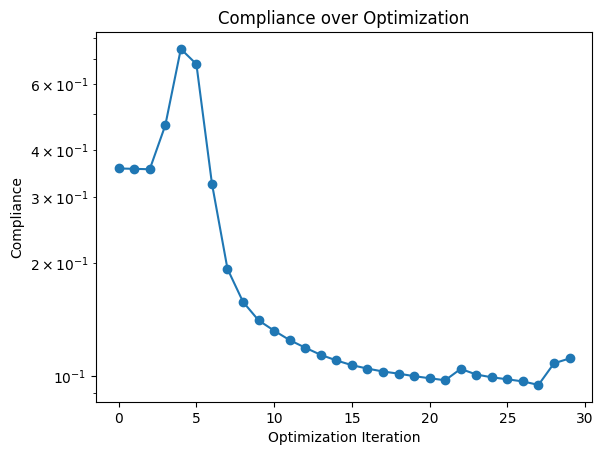

In [58]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [59]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=2).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim_sum_2.gif", writer="pillow", fps=10)

In [ ]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")